In [129]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import os
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm
import re
import skimage.transform
import cv2
from pykuwahara import kuwahara
import pandas as pd
from scipy import stats

import random

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_3516/155656595.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


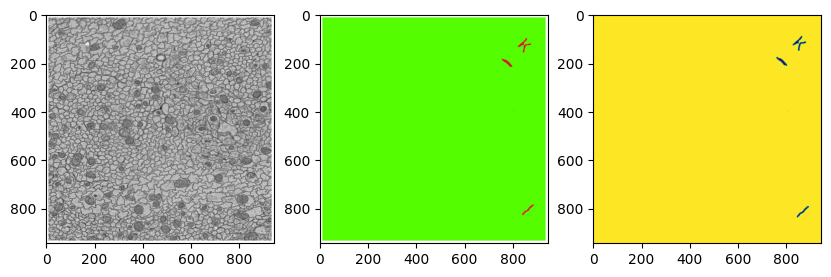

In [130]:
data_dir = os.path.join(".","plain")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

def extract_integers(s):
    return [int(num) for num in re.findall(r'\d+', s)]

def check_index(search_lst):
    intlst = []
    for i in search_lst:
        if i != ".DS_Store":
            intlst.append(extract_integers(i)[0])
    unique_lst = list(set(intlst))
    unique_lst.sort()
    return unique_lst

def image_open(dir, num, backbone):
    img = Image.open(dir + "/" + str(num) + backbone).convert("RGB")
    # img = img.resize((1200, 1200))
    bbox = img.getbbox()
    img = img.crop(bbox)
    return img

backbone_raw = "_raw.jpeg"
backbone_rawindex = "_raw.npy"
backbone_cleft = "_cleft.jpeg"
backbone_cleftindex = "_cleft.npy"
backbone_neuron = "_neuron.jpeg"
backbone_neuronindex = "_neuron.npy"

train_int = check_index(train_fns)
# print(train_int)
val_int = check_index(val_fns)

indd = 100
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
raw_testimg = image_open(train_dir, train_int[indd], backbone_raw)
raw_index = np.load(train_dir + "/" + str(train_int[indd]) + backbone_rawindex) # neuron index read from file
neuron_testimg = image_open(train_dir, train_int[indd], backbone_cleft)
neuron_index = np.load(train_dir + "/" + str(train_int[indd]) + backbone_cleftindex) # neuron index read from file
cleft_testimg = image_open(train_dir, train_int[indd], backbone_cleft)


def ndarray_to_image(array):
    """
    Convert a NumPy array to a PIL Image object.

    Parameters:
    - array: A NumPy array to be converted.

    Returns:
    - A PIL Image object.
    """
    # Ensure the array is of type uint8
    if array.dtype != np.uint8:
        # Normalize and convert the data to uint8
        array = ((array - array.min()) / (array.max() - array.min()) * 255).astype(np.uint8)
    return Image.fromarray(array)

neuron_index = skimage.transform.resize(neuron_index, (944,944))
neuron_index = ndarray_to_image(neuron_index)

axes[0].imshow(raw_testimg)
axes[1].imshow(neuron_testimg)
axes[2].imshow(neuron_index)

In [131]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [132]:
num_items = 10000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(10000, 3)
[[178  14  78]
 [146  24 116]
 [ 85  53 218]
 [246 160 141]
 [142  83  47]]


In [133]:
num_classes = 50
acc = 100
initial_centroids = [i/100 for i in range(100)]

label_model = KMeans(n_clusters=num_classes)
# label_model = KMeans(n_clusters=len(initial_centroids), init=initial_centroids, n_init=1)

label_model.fit(color_array)
print(label_model.cluster_centers_)


/opt/homebrew/Caskroom/miniforge/base/envs/uwzihan/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[ 43.03111111 166.17777778 111.00888889]
 [ 38.61988304 102.84210526 223.09356725]
 [168.95522388  72.78109453  92.30845771]
 [151.93965517 226.50431034 209.22844828]
 [157.62910798 102.22065728 163.19248826]
 [ 35.61032864  91.46478873  92.61971831]
 [194.33333333 153.83809524  23.93809524]
 [ 95.15        42.01818182  40.13636364]
 [ 90.8019802   33.11386139 173.34653465]
 [124.68493151 173.57990868 152.1826484 ]
 [171.14364641  30.71270718 159.8839779 ]
 [229.08982036 223.07185629  41.2754491 ]
 [226.03045685  32.15228426 214.86294416]
 [106.10160428 114.4171123   86.78609626]
 [225.20253165 147.84177215 226.13291139]
 [160.59913793 160.50431034  90.50862069]
 [ 68.32777778 227.20555556 225.21666667]
 [103.2768595  173.37190083  38.51239669]
 [ 93.25405405 101.48648649 145.3027027 ]
 [ 58.75       226.39        25.555     ]
 [230.625      169.38020833  82.33854167]
 [ 47.52083333  28.97916667 227.046875  ]
 [ 33.78021978  26.54945055 102.29120879]
 [ 29.98324022  33.44692737  31.  

In [134]:
label_model.predict(color_array[:5, :])

array([43, 31, 21, 24, 49], dtype=int32)

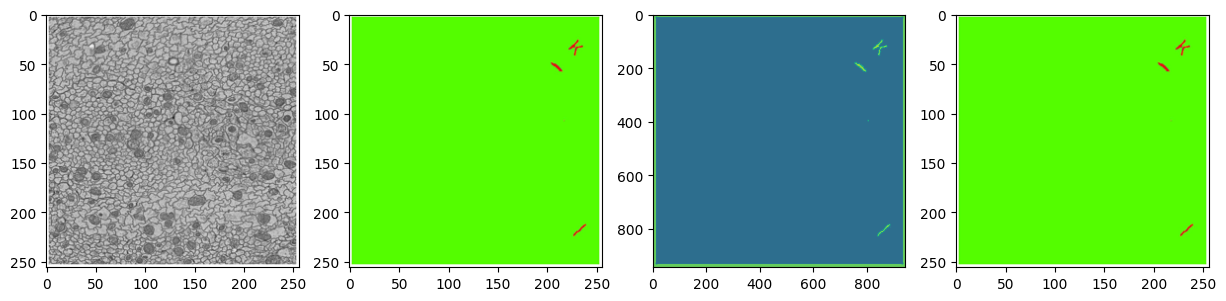

In [135]:
label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(944, 944)

raw_index = skimage.transform.resize(raw_index, (256,256))
# neuron_index = skimage.transform.resize(neuron_index, (256,256))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
im1 = axes[0].imshow(raw_testimg.resize((256,256)))
im2 = axes[1].imshow(neuron_testimg.resize((256,256)))
im3 = axes[2].imshow(label_class)
im4 = axes[3].imshow(cleft_testimg.resize((256,256)))
# cbar = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# for ax in axes:
#     ax.axis('off')

# print(f"neuron_testimg: {np.array(neuron_testimg)}")
unique_elements, counts = np.unique(label_class, return_counts=True)
# print((unique_elements, counts))

In [136]:
def apply_clahe(img):
    img_np = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img_np.shape) == 2:  # Grayscale image
        img_clahe = clahe.apply(img_np)
    else:  # Color image
        img_clahe = np.dstack([clahe.apply(i) for i in cv2.split(img_np)])
    return Image.fromarray(img_clahe)

# Define a custom transform for Canny edge detection
def apply_canny(img):
    img_np = np.array(img.convert('L'))  # Convert to grayscale
    edges = cv2.Canny(img_np, 100, 200)
    return Image.fromarray(edges).convert('RGB')  # Convert back to RGB

def most_common(lst):
    try: 
        val = max(set(lst), key=lst.count)
    except ValueError:
        val = 1e10
    return val

def apply_smooth(img):
    half_width = 1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            target = img[i][j]
            backlst = []
            for ii in range(max(0, i-half_width), min(img.shape[0], i+half_width+1)):
                for jj in range(max(1, j-half_width), min(img.shape[1], j+half_width+1)):
                    backlst.append(img[ii][jj])
            # print(backlst)
            new_target = most_common(backlst)
            img[i][j] = new_target
        
    return img

In [137]:
class NeuronDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.index_lst = check_index(self.image_fns)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns) // 6
    
    def __getitem__(self, index):
        # assert index in self.index_lst
        raw_testimg = image_open(train_dir, index, backbone_raw)
        raw_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_rawindex) # neuron index read from file
        neuron_testimg = image_open(train_dir, index, backbone_cleft).resize((256,256))
        label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(256, 256)
        neuron_index = np.load(train_dir + "/" + str(index) + backbone_cleftindex)
         
        raw_index = skimage.transform.resize(raw_index, (256,256))
        neuron_index = skimage.transform.resize(neuron_index, (256,256)) 
        raw_testimg = raw_testimg.resize((256,256))
        # label_class = skimage.transform.resize(label_class, (256,256))

        test = 0
    
        # preprocess
        raw_testimg = np.array(raw_testimg)
        raw_testimg = self.transform(raw_testimg)

        if test == 1:
            raw_testimg = np.array(raw_testimg).transpose(1,2,0)
            plt.figure()
            print(np.array(raw_testimg).shape)
            plt.imshow(raw_testimg)
        
        raw_index = torch.Tensor(raw_index).long() 
        minval = np.min(neuron_index)
        neuron_index = torch.Tensor(neuron_index / minval).long()

        if test == 1: 
            print(label_class)
            print(f"type label_class: {type(label_class)}")
        
        label_class = apply_smooth(label_class)
        label_class = torch.Tensor(label_class).long()

        if test == 1: 
            # print(label_class.numpy())
            plt.figure()
            plt.imshow(label_class)
         
        return raw_testimg, label_class
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            # transforms.Lambda(lambda img: apply_clahe(img)),
            # transforms.Lambda(lambda img: apply_canny(img)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [228]:
def generate_random_regions(size, num_regions=5, min_region_size=10, max_region_size=50):
    regions = []

    for _ in range(num_regions):
        width, height = size

        # Randomly determine the size of the region
        region_width = random.randint(min_region_size, max_region_size)
        region_height = random.randint(min_region_size, max_region_size)

        # Randomly determine the starting point of the region
        x_start = random.randint(0, width - region_width)
        y_start = random.randint(0, height - region_height)

        # Calculate the end points of the region
        x_end = x_start + region_width
        y_end = y_start + region_height

        regions.append((x_start, x_end, y_start, y_end))

    return regions

def perturb_segmentation_aggressively(label_graph, perturbation_radius=3, high_perturb_probability=0.9, low_perturb_probability=0.5, num_high_perturb_regions=10, min_region_size=20, max_region_size=80):
    # Generate random high perturbation regions
    rows, cols = label_graph.shape
    high_perturb_regions = generate_random_regions((rows, cols), num_high_perturb_regions, min_region_size, max_region_size)

    # Helper function to check if a point is in a high perturbation region
    def in_high_perturb_region(x, y, regions):
        for region in regions:
            if region[0] <= x < region[1] and region[2] <= y < region[3]:
                return True
        return False

    # Create a copy of the graph to perturb
    perturbed_graph = np.array(label_graph)

    # Iterate over each point in the graph
    for x in range(rows):
        for y in range(cols):
            # Determine the probability of perturbation for this point
            if in_high_perturb_region(x, y, high_perturb_regions):
                perturb_probability = high_perturb_probability
            else:
                perturb_probability = low_perturb_probability

            # Randomly decide whether to perturb this point
            if random.random() < perturb_probability:
                # Define the neighborhood boundary
                x_min = max(x - perturbation_radius, 0)
                x_max = min(x + perturbation_radius + 1, rows)
                y_min = max(y - perturbation_radius, 0)
                y_max = min(y + perturbation_radius + 1, cols)

                # Extract the neighborhood
                neighborhood = label_graph[x_min:x_max, y_min:y_max]

                # Choose a random point from the neighborhood
                random_point = neighborhood[np.random.randint(0, neighborhood.shape[0]), 
                                            np.random.randint(0, neighborhood.shape[1])]

                # Update the label of the current point
                perturbed_graph[x, y] = random_point

    return perturbed_graph


def extract_label_boundaries(label_array):
    boundaries = {}
    unique_labels = np.unique(label_array)

    for label in unique_labels:
        # Create a mask for the current label
        mask = np.where(label_array == label, 255, 0).astype(np.uint8)
        # Find contours (boundaries) of the label
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Store the contours in the dictionary
        boundaries[label] = contours
        # print(contours)

    return boundaries

def remove_element(lst, element_to_remove):
    return [element for element in lst if element != element_to_remove]


def perturb_labels_smooth(labels, kernel_size=5, erosion_iter=3, dilation_iter=3):
    # Create circular (elliptical) kernels for erosion and dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # Apply erosion to reduce the label size with a smoother effect
    eroded_labels = cv2.erode(labels.astype(np.uint8), kernel, iterations=erosion_iter)
    
    # Apply dilation to restore the label size with a smoother effect
    dilated_labels = cv2.dilate(eroded_labels, kernel, iterations=dilation_iter)
    
    return dilated_labels

def iter_boundary(img, boundary, prob=1, radius=5, ind=10):
    keys = list(boundary.keys())
    for i in keys:
        thebound = boundary[i][0]
        for pt_ind in thebound:
            rand = random.uniform(0,1)
            if rand < prob:
                pt_ind = pt_ind[0]
                ptx, pty = pt_ind[0], pt_ind[1]
                for ptxx in range(max(0, ptx-random.randint(1,ind)),min(img.shape[0], ptx+random.randint(1,ind))):
                    for ptyy in range(max(0, pty-random.randint(1,ind)), min(img.shape[1], pty+random.randint(1,ind))):
                        lst = []
                        for i in range(max(0, ptxx-radius), min(img.shape[0], ptxx+radius)):
                            for j in range(max(0, ptyy-radius), min(img.shape[1], ptyy+radius)):
                                lst.append(img[i][j])
                        lv = img[ptxx][ptyy]
                        # print(lv)
                        lst = remove_element(lst, lv)
                        # print(lst)
                        ll = most_common(lst)
                        # print(f"diff: {ll-lv}")
                        if ll == 1e10:
                            img[ptxx][ptyy] = lv
                        else:
                            img[ptxx][ptyy] = ll
                
                
    return img

def find_sig(img, cut=0.5):
    indexlst = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > cut:
                indexlst.append((i,j))
    print(indexlst)

303
torch.Size([3, 256, 256]) torch.Size([256, 256])
(248, 248)


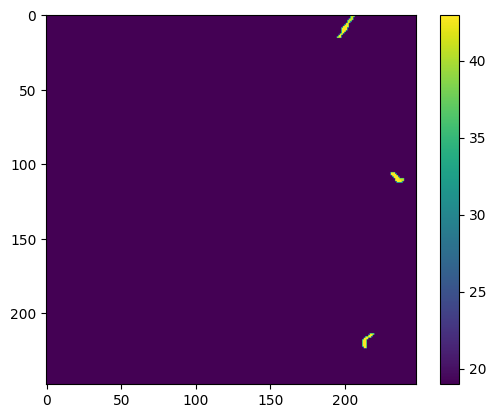

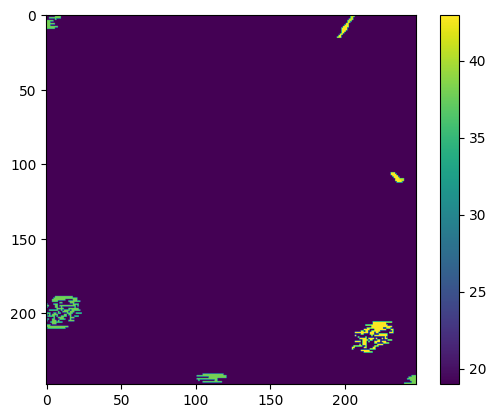

In [244]:
dataset = NeuronDataset(train_dir, label_model)
print(len(dataset))
raw_image, label_class = dataset[10]
print(raw_image.shape, label_class.shape)


plt.figure()
plt.imshow(label_class[4:-4, 4:-4])
plt.colorbar()

# single test
label_class = np.array(label_class)
boundary = extract_label_boundaries(label_class)
new_label = iter_boundary(label_class, boundary, 0.5)

new_label = label_class[4:-4, 4:-4]

# plt.figure()
# plt.imshow(new_label)

put_label = perturb_labels_smooth(new_label, kernel_size=10, erosion_iter=5, dilation_iter=5)
# put_label = find_sig(new_label)

plt.figure()
plt.imshow(new_label)
plt.colorbar()

print(new_label.shape)

In [245]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [246]:
model = UNet(num_classes=num_classes)

In [247]:
# from torchviz import make_dot
# import hiddenlayer as hl
# from torch.utils.tensorboard import SummaryWriter


# x = torch.randn(1, 3, 256, 256)  # Example input tensor matching the input size of your network
# y = model(x)
# dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
# dot.render('unet_graph', format='png')  # This will save the graph as 'unet_graph.png'

# writer = SummaryWriter()
# images = vutils.make_grid(images, normalize=True, scale_each=True)
# dummy_input = torch.randn(1, 3, 256, 256)
# writer.add_graph(model, dummy_input)
# writer.add_image('Image', images, 0)
# writer.close()

303 76
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
torch.Size([4, 50, 256, 256])


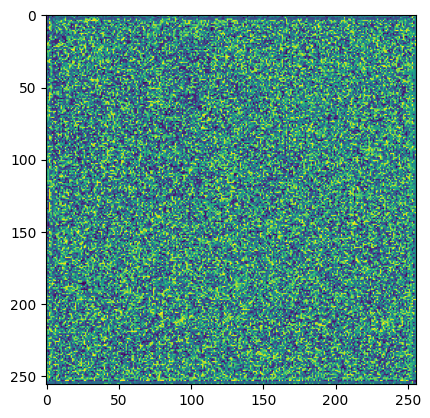

In [248]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

Y_pred = model(X)
print(Y_pred.shape)

Y_pred = torch.argmax(Y_pred, dim=1)
plt.imshow(Y_pred[2].cpu().detach().numpy())

In [249]:
batch_size = 32

epochs = 15
lr = 0.01

In [250]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)  # Apply softmax to the inputs
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)  # Apply softmax to the inputs

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [251]:
dataset = NeuronDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)
model = UNet(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss()
optimizer = optim.Adam(model.parameters())

step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Losses')

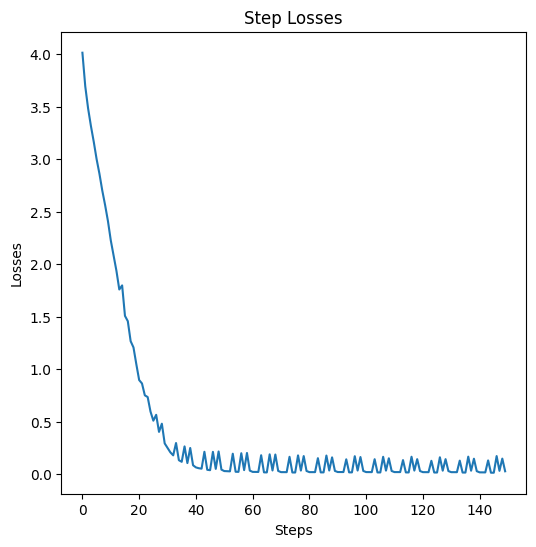

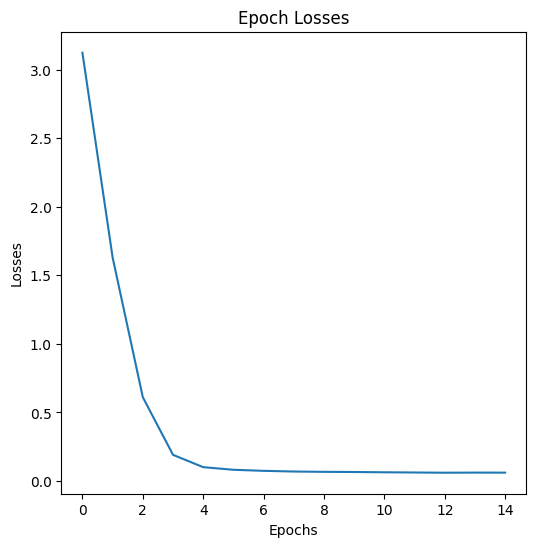

In [252]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.figure(figsize=(6,6))
plt.plot(step_losses)
plt.title("Step Losses")
plt.xlabel("Steps")
plt.ylabel("Losses")
# axes[0].set_yscale('log')

plt.figure(figsize=(6,6))
plt.plot(epoch_losses)
plt.title("Epoch Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
# axes[1].set_yscale('log')


In [253]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

In [254]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [255]:
test_batch_size = 2
dataset = NeuronDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [256]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
print(X.shape, Y.shape)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmin(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([2, 3, 256, 256]) torch.Size([2, 256, 256])
torch.Size([2, 50, 256, 256])
torch.Size([2, 256, 256])


In [257]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Text(0.5, 1.0, 'Label Class - Predicted')

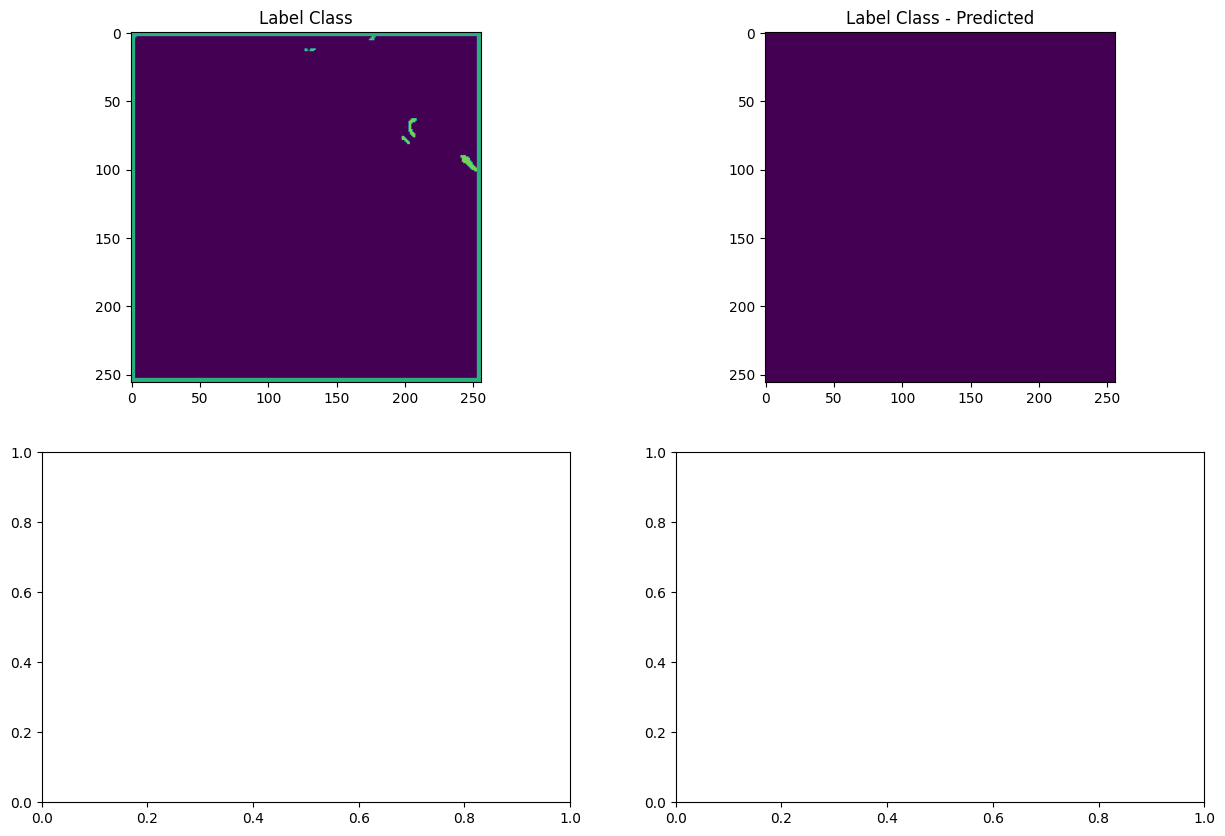

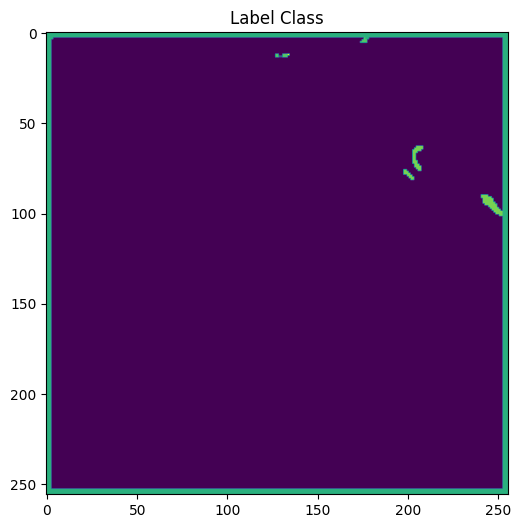

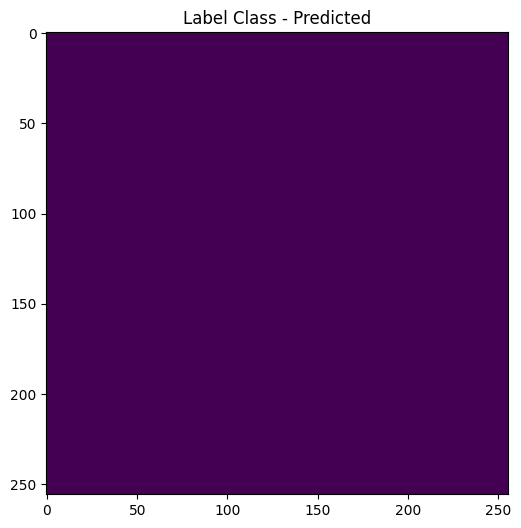

In [259]:
fig, axes = plt.subplots(test_batch_size, 2, figsize=(3*5, test_batch_size*5))

# for i in range(1):
    
#     landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
#     label_class = Y[i].cpu().detach().numpy()
#     label_class_predicted = Y_pred[i].cpu().detach().numpy()

#     # perturb_label = perturb_segmentation_aggressively(label_class)
    
#     # axes[i, 0].imshow(landscape)
#     # axes[i, 0].set_title("Landscape")
#     axes[i, 0].imshow(label_class)
#     axes[i, 0].set_title("Label Class")
#     axes[i, 1].imshow(perturb_labels_smooth(label_class,kernel_size=7))
#     axes[i, 1].set_title("Label Class - Predicted")

plt.figure(figsize=(6,6))
plt.imshow(label_class)
plt.title("Label Class")
plt.figure(figsize=(6,6))
plt.imshow(perturb_labels_smooth(label_class,kernel_size=7))
plt.title("Label Class - Predicted")
